# Installing Packages and Creating a spark session.


In [24]:
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np
import pyarrow as pa
from tqdm import tqdm, trange, tqdm_notebook
from time import sleep
from math import sqrt
import glob
import os
import re

from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

from sklearn.pipeline import make_pipeline
from sklearn import datasets
# #Iris Dataset
# iris = datasets.load_iris()

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()

import pandas as pd
from sklearn import preprocessing
import boto3
import io
import pandas as pd
import pyarrow.parquet as pq

from pandas import DataFrame
import pyspark
from pyspark.sql import SparkSession
import plotly
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.context import SparkContext

sc = SparkContext("local", "App Name")


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=App Name, master=local) created by __init__ at <ipython-input-1-7e6fc0e2c059>:43 

In [25]:

# Folder Name
from os import listdir
from os.path import isfile, join
mypath = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

 # Testing Tile variables

In [26]:
TILE_X = 7680
TILE_Y = 10240

(start_x, start_y) = (0, 0)
(size_x, size_y) = (512, 512)

cropbox = (start_x, start_y, start_x + size_x, start_y + size_y)

# Defining Mask Functions

In [27]:
# Get the physical path to the PNG image containing the mask file
def get_mask_path(tile_x, tile_y):
    path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\'
    path += f"masks\\mask-x{tile_x}-y{tile_y}.png"
    #path += f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    #path = f'E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\'
    return path


# assert os.path.isfile(mask_path)


# Mask Functions from Simar
def get_mask_path(tile_x, tile_y):
    path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\'
    path += f"masks\\mask-x{tile_x}-y{tile_y}.png"
#     path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    return path


def load_image(tile_path):
    img = Image.open(tile_path)
    return img


def get_tile_pixels(img):
    pixels = img.load()
    return pixels


def plot_image(img):
    plt.imshow(img)
    

def is_in_mask(mask_pixels, pixel_x, pixel_y):
    if mask_pixels[pixel_y, pixel_x] == (0, 0, 0, 255):
        return True
    else:
        return False
    
def pixels_in_mask(tile_x, tile_y):
    pixel_list = []
    
    mask_path = get_mask_path(tile_x, tile_y)    
    mask_img = load_image(mask_path)    
    mask_pix = get_tile_pixels(mask_img)    
    mask_img_size = mask_img.size
    
    for pixel_x in range(0,mask_img.size[0]):
        for pixel_y in range(0,mask_img.size[1]):
            in_mask = is_in_mask(mask_pix, pixel_x, pixel_y)
            if in_mask:
                pixel_list.append(str(pixel_y)+ " "+ str(pixel_x))
    return pixel_list


# Testing on Tile 


mask_path = get_mask_path(TILE_X, TILE_Y)
print(mask_path)
print(get_tile_pixels(load_image(mask_path)))


C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\masks\mask-x7680-y10240.png


# Image Functions

In [28]:
def open_image(path, mode = None, cropbox = None, verbose = True):
    if verbose:
        print(path)
    img = Image.open(path)
    if cropbox is not None:
        img = img.crop(cropbox)
    if mode is not None:
        img = img.convert(mode)
    if verbose:
        print("Format: {0}\nSize: {1}\nMode: {2}".format(img.format, img.size, img.mode))
        (width, height) = img.size
        print('width:',width,'height:',height)
    return img



masp = open_image(mask_path, mode = 'P', cropbox = cropbox)



# masp

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\masks\mask-x7680-y10240.png
Format: None
Size: (512, 512)
Mode: P
width: 512 height: 512


# Count the pixels in Mask

In [29]:
# c
mask_pixels = pixels_in_mask(7680, 10240)
len(mask_pixels)


174278

# Time series Functions

In [7]:
def get_timeseries_image_paths(tile_x, tile_y, band):
    path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\'
    path += f"sugarcanetiles\\{tile_x}-{tile_y}-{band}*.png"
    #print(path)
    images = glob.glob(path)
    return images

In [8]:
#Testing definitions
tci_list = get_timeseries_image_paths(TILE_X, TILE_Y, 'TCI')
tci_list[-1]

'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles\\7680-10240-TCI-2019-08-09.png'

In [9]:
# GettingList of 
def last_date_in_path(path):
    return re.findall('\d{4}-\d{2}-\d{2}',path)[-1]

tci_list = get_timeseries_image_paths(TILE_X, TILE_Y, 'TCI')
test_path = tci_list[-1]
print(test_path)
print(last_date_in_path(test_path))

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2019-08-09.png
2019-08-09


In [11]:
def write_to_excel(df, file_name, sheet_name='sheet1'):
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheet_name)
    writer.save()

In [12]:
columns = ['tile_x','tile_y', 'x','y', 'date', 'mask', 'red','green','blue', ]
columns.extend([f'B{b:02d}' for b in range(1,13)])
print(columns)

['tile_x', 'tile_y', 'x', 'y', 'date', 'mask', 'red', 'green', 'blue', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12']


In [13]:
b_name_list = [f'B{b:02d}' for b in range(1,13)]
b_path_lol = [get_timeseries_image_paths(TILE_X, TILE_Y, b) for b in b_name_list]
b_path_lol[-5][-1]

'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles\\7680-10240-B08-2019-08-09.png'

In [14]:
def read_img_pixel_values(tile_x, tile_y, date, *args):
    """ return array of arrays 
        one array for each pixel (10m X 10 m), containing 
        an array for each spectrum value for the pixel
    """
    int_max = 2**15-1
    for img in (args):
        assert img.size == args[0].size
    (width, height) = args[0].size
    #print('width',width,'height',height)

    pixl_list = [img.load() for img in args]

    result_list = []
    for x in range(0, width):
        for y in range(0, height):
            val_list = [tile_x, tile_y, x, y, date]
            for pix in pixl_list:
                val = pix[x,y]
                if isinstance(val, tuple):
                    val_list.extend(val)
                else:
                    val_list.append(val)
            #print(val_list)
            result_list.append(val_list)
    return result_list

In [44]:
def overlayPredictionImage(df, tci, overlay_colour):
    """ overlay harvest predition onto image
        df - pandas dataframe with 'x', 'y' and 'prediction' integer columns
        tci - rgb image
        overlay_colour - list of np.array([r,g,b], dtype='uint8') representing the colours to overlay
        return a numpy array x by y by [r,g,b]
    """
    result = np.array(tci)
    for row in df.itertuples():
        result[row.y,row.x] = overlay_colour[row.prediction]
    return result

In [15]:
# IterrateTiles.dtypes
# prin"t(len(IterrateTiles['Y Tile']))
# print(len(IterrateTiles['X Tile']))

SyntaxError: EOL while scanning string literal (<ipython-input-15-e54c5e806f95>, line 2)

In [16]:
#for tci_path, b_path_list in tqdm(list(zip(tci_list,b_path_lol))):
ModelDF = pd.DataFrame()
assert len(tci_list) == len(b_path_lol[0])
(tile_x, tile_y) = (TILE_X, TILE_Y)
for day_no in trange(0,14): # len(tci_list)):
    tci_path = tci_list[day_no]
    date = last_date_in_path(tci_path)
    b_path_list = [b_path_list[day_no] for b_path_list in b_path_lol]

    tci_img = open_image(tci_path, cropbox = cropbox, verbose=False)
    b_img_list = [open_image(b_path, cropbox = cropbox, verbose=False) for b_path in b_path_list]

    data = read_img_pixel_values(tile_x, tile_y, date, masp, tci_img, *b_img_list)

    df = pd.DataFrame(columns=columns, data=data)
    # apply a very very simple havested rules
    df['clouds'] = df.apply(lambda df : df.red == df.green and df.red == df.blue, axis=1)
    df['havested'] = df.apply(lambda df : df.red > df.green, axis=1)

    # Calculate Indices:
    # https://support.micasense.com/hc/en-us/articles/227837307-An-overview-of-the-available-layers-and-indices-in-Atlas
    # https://support.micasense.com/hc/en-us/articles/226531127-Creating-agricultural-indices-NDVI-NDRE-from-an-Atlas-GeoTIFF-in-QGIS-
    # https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
    # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/
    # NDVI ref: https://medium.com/analytics-vidhya/satellite-imagery-analysis-with-python-3f8ccf8a7c32

    # NDVI - Normalised Difference Vegetation Index (NDVI)
    #  = (NIR - RED) / (NIR + RED)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_361.js
    df['NDVI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B04)) / (df.B08 + df.B04)) , axis=1)

    # GNDVI - Green Normalized Difference NDVI
    #  = (NIR - GREEN)/(NIR + GREEN)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTm9ybWFsaXplZCBEaWZmZXJlbmNlIE5JUi9HcmVlbiBHcmVlbiBORFZJIChhYmJydi4gR05EVkkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKE5JUi1HUkVFTikvKE5JUitHUkVFTikKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD00MDEKLy8KCmxldCBpbmRleCA9IChCMDggLSBCMDMpIC8gKEIwOCArIEIwMyk7CmxldCBtaW4gPSAtMC44OTsKbGV0IG1heCA9IDAuODk7CmxldCB6ZXJvID0gMC4wOwoKLy8gY29sb3JCbGVuZCB3aWxsIHJldHVybiBhIGNvbG9yIHdoZW4gdGhlIGluZGV4IGlzIGJldHdlZW4gbWluIGFuZCBtYXggYW5kIHdoaXRlIHdoZW4gaXQgaXMgbGVzcyB0aGFuIG1pbi4KLy8gVG8gc2VlIGJsYWNrIHdoZW4gaXQgaXMgbW9yZSB0aGFuIG1heCwgdW5jb21tZW50IHRoZSBsYXN0IGxpbmUgb2YgY29sb3JCbGVuZC4KLy8gVGhlIG1pbi9tYXggdmFsdWVzIHdlcmUgY29tcHV0ZWQgYXV0b21hdGljYWxseSBhbmQgbWF5IGJlIHBvb3JseSBzcGVjaWZpZWQsIGZlZWwgZnJlZSB0byBjaGFuZ2UgdGhlbSB0byB0d2VhayB0aGUgZGlzcGxheWVkIHJhbmdlLgovLyBUaGlzIGluZGV4IGNyb3NzZXMgemVybywgc28gYSBkaXZlcmdpbmcgY29sb3IgbWFwIGlzIHVzZWQuIFRvIHR3ZWFrIHRoZSB2YWx1ZSBvZiB0aGUgYnJlYWsgaW4gdGhlIGNvbG9yIG1hcCwgY2hhbmdlIHRoZSB2YXJpYWJsZSAnemVybycuCgpsZXQgdW5kZXJmbG93X2NvbG9yID0gWzEsIDEsIDFdOwpsZXQgbG93X2NvbG9yID0gWzIwOC8yNTUsIDg4LzI1NSwgMTI2LzI1NV07CmxldCBoaWdoX2NvbG9yID0gWzI0MS8yNTUsIDIzNC8yNTUsIDIwMC8yNTVdOwpsZXQgemVyb19jb2xvciA9IFswLCAxNDcvMjU1LCAxNDYvMjU1XTsKbGV0IG92ZXJmbG93X2NvbG9yID0gWzAsIDAsIDBdOwoKcmV0dXJuIGNvbG9yQmxlbmQoaW5kZXgsIFttaW4sIG1pbiwgemVybywgbWF4XSwKWwoJdW5kZXJmbG93X2NvbG9yLAoJbG93X2NvbG9yLAoJemVyb19jb2xvciwgLy8gZGl2ZXJnZW50IHN0ZXAgYXQgemVybwoJaGlnaF9jb2xvciwKCS8vb3ZlcmZsb3dfY29sb3IgLy8gdW5jb21tZW50IHRvIHNlZSBvdmVyZmxvd3MKXSk7DQo%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_401.js
    df['GNDVI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B03)) / (df.B08 + df.B03)) , axis=1)

    # RDVI - Normalised Difference Vegetation Index (NDVI)
    #  = 2*(NIR - RED) / sqrt(NIR + RED)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gUmVub3JtYWxpemVkIERpZmZlcmVuY2UgVmVnZXRhdGlvbiBJbmRleCAgIChhYmJydi4gUkRWSSkKLy8KLy8gR2VuZXJhbCBmb3JtdWxhOiAoODAwbm0gLSA2NzBubSkgL3NxcnQoODAwbm0gKyA2NzBubSkwLjUKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD03NgovLwoKbGV0IGluZGV4ID0gKEIwOCAtIEIwNCkgLyBNYXRoLnNxcnQoQjA4ICsgQjA0KSAqIDAuNTsKbGV0IG1pbiA9IC0wLjI2NjsKbGV0IG1heCA9IDAuMjY2OwpsZXQgemVybyA9IDAuMDsKCi8vIGNvbG9yQmxlbmQgd2lsbCByZXR1cm4gYSBjb2xvciB3aGVuIHRoZSBpbmRleCBpcyBiZXR3ZWVuIG1pbiBhbmQgbWF4IGFuZCB3aGl0ZSB3aGVuIGl0IGlzIGxlc3MgdGhhbiBtaW4uCi8vIFRvIHNlZSBibGFjayB3aGVuIGl0IGlzIG1vcmUgdGhhbiBtYXgsIHVuY29tbWVudCB0aGUgbGFzdCBsaW5lIG9mIGNvbG9yQmxlbmQuCi8vIFRoZSBtaW4vbWF4IHZhbHVlcyB3ZXJlIGNvbXB1dGVkIGF1dG9tYXRpY2FsbHkgYW5kIG1heSBiZSBwb29ybHkgc3BlY2lmaWVkLCBmZWVsIGZyZWUgdG8gY2hhbmdlIHRoZW0gdG8gdHdlYWsgdGhlIGRpc3BsYXllZCByYW5nZS4KLy8gVGhpcyBpbmRleCBjcm9zc2VzIHplcm8sIHNvIGEgZGl2ZXJnaW5nIGNvbG9yIG1hcCBpcyB1c2VkLiBUbyB0d2VhayB0aGUgdmFsdWUgb2YgdGhlIGJyZWFrIGluIHRoZSBjb2xvciBtYXAsIGNoYW5nZSB0aGUgdmFyaWFibGUgJ3plcm8nLgoKbGV0IHVuZGVyZmxvd19jb2xvciA9IFsxLCAxLCAxXTsKbGV0IGxvd19jb2xvciA9IFsyMDgvMjU1LCA4OC8yNTUsIDEyNi8yNTVdOwpsZXQgaGlnaF9jb2xvciA9IFsyNDEvMjU1LCAyMzQvMjU1LCAyMDAvMjU1XTsKbGV0IHplcm9fY29sb3IgPSBbMCwgMTQ3LzI1NSwgMTQ2LzI1NV07CmxldCBvdmVyZmxvd19jb2xvciA9IFswLCAwLCAwXTsKCnJldHVybiBjb2xvckJsZW5kKGluZGV4LCBbbWluLCBtaW4sIHplcm8sIG1heF0sClsKCXVuZGVyZmxvd19jb2xvciwKCWxvd19jb2xvciwKCXplcm9fY29sb3IsIC8vIGRpdmVyZ2VudCBzdGVwIGF0IHplcm8KCWhpZ2hfY29sb3IsCgkvL292ZXJmbG93X2NvbG9yIC8vIHVuY29tbWVudCB0byBzZWUgb3ZlcmZsb3dzCl0pOw0K&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_76.js
    df['RDVI'] = df.apply(lambda df : int(10000 * 2 * (float(df.B08) - float(df.B04)) / sqrt(df.B08 + df.B04)) , axis=1)

    # RBNDVI - Red Blue Normalised Difference Vegetation Index (NDVI)
    #  = (NIR - RED -BLUE) / (NIR + RED + BLUE)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gUmVkLUJsdWUgTkRWSSAgKGFiYnJ2LiBSQk5EVkkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKE5JUi0oUkVEK0JMVUUpKS8oTklSKyhSRUQrQkxVRSkpCi8vCi8vIFVSTCBodHRwczovL3d3dy5pbmRleGRhdGFiYXNlLmRlL2RiL3NpLXNpbmdsZS5waHA%2Fc2Vuc29yX2lkPTk2JnJzaW5kZXhfaWQ9MTg3Ci8vCgpsZXQgaW5kZXggPSAoQjA4IC0gKEIwNCArIEIwMikpIC8gKEIwOCArIChCMDQgKyBCMDIpKTsKbGV0IG1pbiA9IC0wLjkzOTsKbGV0IG1heCA9IDAuNTI5OwpsZXQgemVybyA9IDAuMDsKCi8vIGNvbG9yQmxlbmQgd2lsbCByZXR1cm4gYSBjb2xvciB3aGVuIHRoZSBpbmRleCBpcyBiZXR3ZWVuIG1pbiBhbmQgbWF4IGFuZCB3aGl0ZSB3aGVuIGl0IGlzIGxlc3MgdGhhbiBtaW4uCi8vIFRvIHNlZSBibGFjayB3aGVuIGl0IGlzIG1vcmUgdGhhbiBtYXgsIHVuY29tbWVudCB0aGUgbGFzdCBsaW5lIG9mIGNvbG9yQmxlbmQuCi8vIFRoZSBtaW4vbWF4IHZhbHVlcyB3ZXJlIGNvbXB1dGVkIGF1dG9tYXRpY2FsbHkgYW5kIG1heSBiZSBwb29ybHkgc3BlY2lmaWVkLCBmZWVsIGZyZWUgdG8gY2hhbmdlIHRoZW0gdG8gdHdlYWsgdGhlIGRpc3BsYXllZCByYW5nZS4KLy8gVGhpcyBpbmRleCBjcm9zc2VzIHplcm8sIHNvIGEgZGl2ZXJnaW5nIGNvbG9yIG1hcCBpcyB1c2VkLiBUbyB0d2VhayB0aGUgdmFsdWUgb2YgdGhlIGJyZWFrIGluIHRoZSBjb2xvciBtYXAsIGNoYW5nZSB0aGUgdmFyaWFibGUgJ3plcm8nLgoKbGV0IHVuZGVyZmxvd19jb2xvciA9IFsxLCAxLCAxXTsKbGV0IGxvd19jb2xvciA9IFsyMDgvMjU1LCA4OC8yNTUsIDEyNi8yNTVdOwpsZXQgaGlnaF9jb2xvciA9IFsyNDEvMjU1LCAyMzQvMjU1LCAyMDAvMjU1XTsKbGV0IHplcm9fY29sb3IgPSBbMCwgMTQ3LzI1NSwgMTQ2LzI1NV07CmxldCBvdmVyZmxvd19jb2xvciA9IFswLCAwLCAwXTsKCnJldHVybiBjb2xvckJsZW5kKGluZGV4LCBbbWluLCBtaW4sIHplcm8sIG1heF0sClsKCXVuZGVyZmxvd19jb2xvciwKCWxvd19jb2xvciwKCXplcm9fY29sb3IsIC8vIGRpdmVyZ2VudCBzdGVwIGF0IHplcm8KCWhpZ2hfY29sb3IsCgkvL292ZXJmbG93X2NvbG9yIC8vIHVuY29tbWVudCB0byBzZWUgb3ZlcmZsb3dzCl0pOw0K&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_187.js
    df['RBNDVI'] = df.apply(lambda df : int(10000 * (2*float(df.B08) - float(df.B04) - float(df.B02)) / (2*df.B08 + df.B04 + df.B02)) , axis=1)

    # LCI - Leaf Chlorophyll Index
    #  = (NIR - REDE)/(NIR + REDE)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTGVhZiBDaGxvcm9waHlsbCBJbmRleCAgKGFiYnJ2LiBMQ0kpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFs4NTBdLVs3MTBdKS8oWzg1MF0rWzY4MF0pCi8vCi8vIFVSTCBodHRwczovL3d3dy5pbmRleGRhdGFiYXNlLmRlL2RiL3NpLXNpbmdsZS5waHA%2Fc2Vuc29yX2lkPTk2JnJzaW5kZXhfaWQ9MTA5Ci8vCgpsZXQgaW5kZXggPSAoQjA4IC0gQjA1KSAvIChCMDggKyBCMDQpOwpsZXQgbWluID0gLTIuNzk4OwpsZXQgbWF4ID0gMC43MzU7CmxldCB6ZXJvID0gMC4wOwoKLy8gY29sb3JCbGVuZCB3aWxsIHJldHVybiBhIGNvbG9yIHdoZW4gdGhlIGluZGV4IGlzIGJldHdlZW4gbWluIGFuZCBtYXggYW5kIHdoaXRlIHdoZW4gaXQgaXMgbGVzcyB0aGFuIG1pbi4KLy8gVG8gc2VlIGJsYWNrIHdoZW4gaXQgaXMgbW9yZSB0aGFuIG1heCwgdW5jb21tZW50IHRoZSBsYXN0IGxpbmUgb2YgY29sb3JCbGVuZC4KLy8gVGhlIG1pbi9tYXggdmFsdWVzIHdlcmUgY29tcHV0ZWQgYXV0b21hdGljYWxseSBhbmQgbWF5IGJlIHBvb3JseSBzcGVjaWZpZWQsIGZlZWwgZnJlZSB0byBjaGFuZ2UgdGhlbSB0byB0d2VhayB0aGUgZGlzcGxheWVkIHJhbmdlLgovLyBUaGlzIGluZGV4IGNyb3NzZXMgemVybywgc28gYSBkaXZlcmdpbmcgY29sb3IgbWFwIGlzIHVzZWQuIFRvIHR3ZWFrIHRoZSB2YWx1ZSBvZiB0aGUgYnJlYWsgaW4gdGhlIGNvbG9yIG1hcCwgY2hhbmdlIHRoZSB2YXJpYWJsZSAnemVybycuCgpsZXQgdW5kZXJmbG93X2NvbG9yID0gWzEsIDEsIDFdOwpsZXQgbG93X2NvbG9yID0gWzIwOC8yNTUsIDg4LzI1NSwgMTI2LzI1NV07CmxldCBoaWdoX2NvbG9yID0gWzI0MS8yNTUsIDIzNC8yNTUsIDIwMC8yNTVdOwpsZXQgemVyb19jb2xvciA9IFswLCAxNDcvMjU1LCAxNDYvMjU1XTsKbGV0IG92ZXJmbG93X2NvbG9yID0gWzAsIDAsIDBdOwoKcmV0dXJuIGNvbG9yQmxlbmQoaW5kZXgsIFttaW4sIG1pbiwgemVybywgbWF4XSwKWwoJdW5kZXJmbG93X2NvbG9yLAoJbG93X2NvbG9yLAoJemVyb19jb2xvciwgLy8gZGl2ZXJnZW50IHN0ZXAgYXQgemVybwoJaGlnaF9jb2xvciwKCS8vb3ZlcmZsb3dfY29sb3IgLy8gdW5jb21tZW50IHRvIHNlZSBvdmVyZmxvd3MKXSk7DQo%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_109.js
    df['LCI'] = df.apply(lambda df : int(100 * (float(df.B08) - float(df.B05)) / (df.B08 + df.B05)) , axis=1)

    # LAI - Leaf Area Index
    #  = (REDE - RED)/(REDE + RED)
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231680/
    df['LAI'] = df.apply(lambda df : int(10000 * (float(df.B05) - float(df.B04)) / (df.B05 + df.B04)) , axis=1)

    # SCI - Soil Composition Index
    #  = (SWIR - NIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gU29pbCBDb21wb3NpdGlvbiBJbmRleCAgKGFiYnJ2LiApCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFsxNjAwOjE3MDBdLVs3NjA6ODYwXSkvKFsxNjAwOjE3MDBdK1s3NjA6ODYwXSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD04OAovLwoKbGV0IGluZGV4ID0gKEIxMSAtIEIwOCkgLyAoQjExICsgQjA4KTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_88.js
    df['SCI'] = df.apply(lambda df : int(10000 * (float(df.B11) - float(df.B08)) / (df.B11 + df.B08)) , axis=1)

    # SCI - Soil Composition Index
    #  = (SWIR - NIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gU29pbCBDb21wb3NpdGlvbiBJbmRleCAgKGFiYnJ2LiApCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFsxNjAwOjE3MDBdLVs3NjA6ODYwXSkvKFsxNjAwOjE3MDBdK1s3NjA6ODYwXSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD04OAovLwoKbGV0IGluZGV4ID0gKEIxMSAtIEIwOCkgLyAoQjExICsgQjA4KTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_88.js
    df['SCI'] = df.apply(lambda df : int(10000 * (float(df.B11) - float(df.B08)) / (df.B11 + df.B08)) , axis=1)

    # NDMI - Normalized Difference Moisture Index
    #  = (NIR - SWIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTm9ybWFsaXplZCBEaWZmZXJlbmNlIDgyMC8xNjAwIE5vcm1hbGl6ZWQgRGlmZmVyZW5jZSBNb2lzdHVyZSBJbmRleCAoYWJicnYuIE5ETUkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKDgyMG5tIC0gMTYwMG5tKSAvICg4MjBubSArIDE2MDBubSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD01NgovLwoKbGV0IGluZGV4ID0gKEIwOCAtIEIxMSkgLyAoQjA4ICsgQjExKTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_56.js
    df['NDMI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B11)) / (df.B11 + df.B08)) , axis=1)
    
    # GLI - Green Leaf Index
    #  = (2*GREEN - RED - BLUE)/(2*GREEN + RED + BLUE)
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231680/
    df['GLI'] = df.apply(lambda df : int(10000 * (float(df.B05) - float(df.B04)) / (df.B05 + df.B04)) , axis=1)
    
    ModelDF = pd.concat([ModelDF,df]).reset_index(drop=True)

#     df.to_parquet(f'image_values_{tile_x}_{tile_y}_{date}.snappy.parquet')

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [31:40<00:00, 131.00s/it]


In [17]:
Backup = ModelDF

In [18]:
ModelDF.columns

Index(['tile_x', 'tile_y', 'x', 'y', 'date', 'mask', 'red', 'green', 'blue',
       'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10',
       'B11', 'B12', 'clouds', 'havested', 'NDVI', 'GNDVI', 'RDVI', 'RBNDVI',
       'LCI', 'LAI', 'SCI', 'NDMI', 'GLI'],
      dtype='object')

In [19]:
print(ModelDF.shape)
ModelDF[(ModelDF['red']<225)&(ModelDF['green']<225)&(ModelDF['blue']<225)].shape
Backup.shape


(3670016, 32)


(3670016, 32)

# Modelling

In [32]:
ModelDF = Backup

min_max_scaler = preprocessing.MinMaxScaler()
ModelDF = ModelDF[(ModelDF['red']<225)&(ModelDF['green']<225)&(ModelDF['blue']<225)].reset_index(drop=True)


ModelDF['Scaled_NIR'] = min_max_scaler.fit_transform(ModelDF[['B08']])
ModelDF['Scaled_RED'] = min_max_scaler.fit_transform(ModelDF[['B04']])
ModelDF['Scaled_GRN'] = min_max_scaler.fit_transform(ModelDF[['B03']])
ModelDF['Scaled_NDVI'] = min_max_scaler.fit_transform(ModelDF[['NDVI']])
ModelDF['Scaled_LCI'] = min_max_scaler.fit_transform(ModelDF[['LCI']])
ModelDF['Scaled_LAI'] = min_max_scaler.fit_transform(ModelDF[['LAI']])
ModelDF['Scaled_SCI'] = min_max_scaler.fit_transform(ModelDF[['SCI']])
ModelDF['Scaled_GNDVI'] = min_max_scaler.fit_transform(ModelDF[['GNDVI']])

vegi1InputCols = ['Scaled_NDVI', 'Scaled_LCI', 'Scaled_LAI', 'Scaled_GNDVI', 'Scaled_SCI']
# ['Scaled_NDVI', 'Scaled_LCI', 'Scaled_LAI', 'Scaled_GNDVI', 'Scaled_SCI']

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

Kmean = KMeans(n_clusters=2)
# Kmean.fit(X)

# Kmean  = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
model = Kmean.fit(ModelDF[vegi1InputCols])

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data wit

In [85]:
#Save & Load the model

from sklearn.externals import joblib
filename = '15ImageModel_model.sav'
joblib.dump(model, filename)

model = joblib.load(filename)

In [86]:
Date = df.date.astype(str).head(1)[0]
Date

'2017-02-10'

# Iterating loop

In [55]:
df = df[(df['red']<225)&(df['green']<225)&(df['blue']<225)].reset_index(drop=True)

df['Scaled_NIR'] = min_max_scaler.fit_transform(df[['B08']])
df['Scaled_RED'] = min_max_scaler.fit_transform(df[['B04']])
df['Scaled_GRN'] = min_max_scaler.fit_transform(df[['B03']])
df['Scaled_NDVI'] = min_max_scaler.fit_transform(df[['NDVI']])
df['Scaled_LCI'] = min_max_scaler.fit_transform(df[['LCI']])
df['Scaled_LAI'] = min_max_scaler.fit_transform(df[['LAI']])
df['Scaled_SCI'] = min_max_scaler.fit_transform(df[['SCI']])
df['Scaled_GNDVI'] = min_max_scaler.fit_transform(df[['GNDVI']])

df['PixelTuple'] = df['x'].astype(str) + " " + df['y'].astype(str)

# print(df.shape)
# print(df[df['PixelTuple'].isin(mask_pixels)].shape)
dfMask = df[df['PixelTuple'].isin(mask_pixels)].reset_index(drop=True)

dfMask['prediction']= Kmean.predict(dfMask[vegi1InputCols])

df = df[(df['red']<225)&(df['green']<225)&(df['blue']<225)].reset_index(drop=True)

df['Scaled_NIR'] = min_max_scaler.fit_transform(df[['B08']])
df['Scaled_RED'] = min_max_scaler.fit_transform(df[['B04']])
df['Scaled_GRN'] = min_max_scaler.fit_transform(df[['B03']])
df['Scaled_NDVI'] = min_max_scaler.fit_transform(df[['NDVI']])
df['Scaled_LCI'] = min_max_scaler.fit_transform(df[['LCI']])
df['Scaled_LAI'] = min_max_scaler.fit_transform(df[['LAI']])
df['Scaled_SCI'] = min_max_scaler.fit_transform(df[['SCI']])
df['Scaled_GNDVI'] = min_max_scaler.fit_transform(df[['GNDVI']])

df['PixelTuple'] = df['x'].astype(str) + " " + df['y'].astype(str)
dfMask = df[df['PixelTuple'].isin(mask_pixels)].reset_index(drop=True)

dfMask['prediction']= Kmean.predict(dfMask[vegi1InputCols])




tciFilePath = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles\\7680-10240-TCI-2017-06-20.png'
tci = open_image(tciFilePath, mode='RGB')
numberOfClusters = 5

vegiClustered_df = dfMask[['x','y','prediction']]
colours = []
for colour in range(0, numberOfClusters):
    red = colour * 0xFF / numberOfClusters
    grn = 0xFF - abs(2 * colour - numberOfClusters) * 0xFF / numberOfClusters
    blu = 0xFF - colour * 0xFF / numberOfClusters
    #colours.append(np.array([blu,grn,red,], dtype='uint8'))
    colours.append(np.array([grn,red,blu,], dtype='uint8'))
    #colours.append(np.array([red,grn,blu,], dtype='uint8'))

colours = [
    np.array([0x10,0xAD,0x00], dtype='uint8'),  # limish green
    np.array([0x00,0x26,0xA4], dtype='uint8'),  # blueish
    np.array([0xFF,0x00,0x00], dtype='uint8'),  # red
    np.array([0xFF,0xC6,0x00], dtype='uint8'),  # yellow
    np.array([0x00, 0x00, 0x00],dtype='uint8')
]

clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))
imgnp = overlayPredictionImage(vegiClustered_df, tci, colours)

clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))
clusterImg.to
path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Github\\Dash-Application\\Parquets\\'
path += f"image_values_{tile_x}_{tile_y}_{date}.snappy.parquet"

vegiClustered_df.to_parquet(path)


path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Github\\Dash-Application\\CompImages\\'
path += f"comp_image_{tile_x}_{tile_y}_{date}.snappy.parquet"

clusterImg.save('out.png')



# clusterImg

# imgnp.shape


C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data wit

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2017-06-20.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512


(512, 512, 3)

In [66]:


type(clusterImg)
# clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))


PIL.Image.Image

# Just for Reference

with min_max as (
    select min(B08)  min_NIR
         , min(B04)  min_RED
         , min(B03)  min_GRN
         , min(NDVI) as min_NDVI
         , min(LCI) as min_LCI
         , min(LAI) as min_LAI
         , min(SCI) as min_SCI
         , min(GNDVI) as min_GNDVI

         , max(B08)  max_NIR
         , max(B04)  max_RED
         , max(B03)  max_GRN
         , max(NDVI) as max_NDVI
         , max(LCI) as max_LCI
         , max(LAI) as max_LAI
         , max(SCI) as max_SCI
         , max(GNDVI) as max_GNDVI

    from image
), normalised as (
    select x, y
        , 1.0 * (i.B08 - m.min_NIR) / (m.max_NIR - m.min_NIR) as NIR
        , 1.0 * (i.B04 - m.min_RED) / (m.max_RED - m.min_RED) as RED
        , 1.0 * (i.B03 - m.min_GRN) / (m.max_GRN - m.min_GRN) as GRN
        , 1.0 * (i.NDVI - m.min_NDVI) / (m.max_NDVI - m.min_NDVI) as NDVI
        , 1.0 * (i.LCI - m.min_LCI) / (m.max_LCI - m.min_LCI) as LCI
        , 1.0 * (i.LAI - m.min_LAI) / (m.max_LAI - m.min_LAI) as LAI
        , 1.0 * (i.SCI - m.min_SCI) / (m.max_SCI - m.min_SCI) as SCI
        , 1.0 * (i.GNDVI - m.min_GNDVI) / (m.max_GNDVI - m.min_GNDVI) as GNDVI
    from image i 
    cross join min_max m
    --where i.mask = 0
)
select x,y, NIR, RED, GRN, NDVI, LCI, LAI, GNDVI, SCI
from normalised


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn import datasets
#Iris Dataset
# iris = datasets.load_iris()
vegi1InputCols = ['Scaled_NDVI', 'Scaled_LCI', 'Scaled_LAI', 'Scaled_GNDVI', 'Scaled_SCI']
# ['Scaled_NDVI', 'Scaled_LCI', 'Scaled_LAI', 'Scaled_GNDVI', 'Scaled_SCI']

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Kmean  = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
model = Kmean.fit(ModelDF[vegi1InputCols])
# pred_y = kmeans.fit_predict(ModelDF[vegi1InputCols])

In [ ]:
model.cluster_centers_

In [ ]:
sqlCtx = SQLContext(sc)
spark_df = sqlCtx.createDataFrame(ModelDF)


numberOfClusters = 5

kmeans = KMeans().setK(numberOfClusters).setSeed(1)
vegi1FeaturedDF = VectorAssembler(inputCols=vegi1InputCols, outputCol="features").transform(spark_df)
vegi1ClusteredDF = kmeans.fit(vegi1FeaturedDF.select('features')).transform(vegi1FeaturedDF)

pandas_df = vegi1ClusteredDF.select("*").toPandas()
# print(pandas_df[pandas_df['prediction'] ==2].shape[0])

In [ ]:

# df['PixelTuple']

In [42]:
# Minx



# min_NIR,max_NIR = df['B08'].min(),df['B08'].max()
# min_RED,max_RED = df['B04'].min(),df['B04'].max()
# min_GRN,max_GRN = df['B03'].min(),df['B03'].max()
# min_NDVI,max_NDVI = df['NDVI'].min(),df['NDVI'].max()
# min_LCI,max_LCI = df['LCI'].min(),df['LCI'].max()
# min_LAI,max_LAI = df['LAI'].min(),df['LAI'].max()
# min_SCI,max_SCI = df['SCI'].min(),df['SCI'].max()
# min_GNDVI,max_GNDVI = df['GNDVI'].min(),df['GNDVI'].max()



# min_GRN,max_GRN = df['B03'].min(),df['B03'].max()


C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data wit

In [45]:


# print(df.shape)
# print(df[df['PixelTuple'].isin(mask_pixels)].shape)




C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2017-01-11.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512


(512, 512, 3)

In [ ]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np
# %matplotlib inline
# from sklearn.pipeline import make_pipeline
# from sklearn import datasets
# #Iris Dataset

# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# scaler = StandardScaler()

# scaler = StandardScaler()
# km = KMeans(n_clusters=4)
# # pipeline = make_pipeline(scaler,km)
# vegi1InputCols = ['Scaled_NIR', 'Scaled_RED', 'Scaled_GRN']
# df['prediction'] = pipeline.fit_predict(df[vegi1InputCols])



In [ ]:
# from PIL import Image, ImageDraw
# def open_image(path, mode = None, cropbox = None, verbose = True):
#     if verbose:
#         print(path)
#     img = Image.open(path)
#     if cropbox is not None:
#         img = img.crop(cropbox)
#     if mode is not None:
#         img = img.convert(mode)
#     if verbose:
#         print("Format: {0}\nSize: {1}\nMode: {2}".format(img.format, img.size, img.mode))
#         (width, height) = img.size
#         print('width:',width,'height:',height)
#     return img

tciFilePath = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles\\7680-10240-TCI-2017-01-11.png'
tci = open_image(tciFilePath, mode='RGB')
numberOfClusters = 5

vegiClustered_df = dfMask[['x','y','prediction']]
colours = []
for colour in range(0, numberOfClusters):
    red = colour * 0xFF / numberOfClusters
    grn = 0xFF - abs(2 * colour - numberOfClusters) * 0xFF / numberOfClusters
    blu = 0xFF - colour * 0xFF / numberOfClusters
    #colours.append(np.array([blu,grn,red,], dtype='uint8'))
    colours.append(np.array([grn,red,blu,], dtype='uint8'))
    #colours.append(np.array([red,grn,blu,], dtype='uint8'))

colours = [
    np.array([0x10,0xAD,0x00], dtype='uint8'),  # limish green
    np.array([0x00,0x26,0xA4], dtype='uint8'),  # blueish
    np.array([0xFF,0x00,0x00], dtype='uint8'),  # red
    np.array([0xFF,0xC6,0x00], dtype='uint8'),  # yellow
    np.array([0x00, 0x00, 0x00],dtype='uint8')
]


imgnp = overlayPredictionImage(vegiClustered_df, tci, colours)
imgnp.shape

'2017-06-20'

In [ ]:
# Time Series


In [ ]:
# imgnp


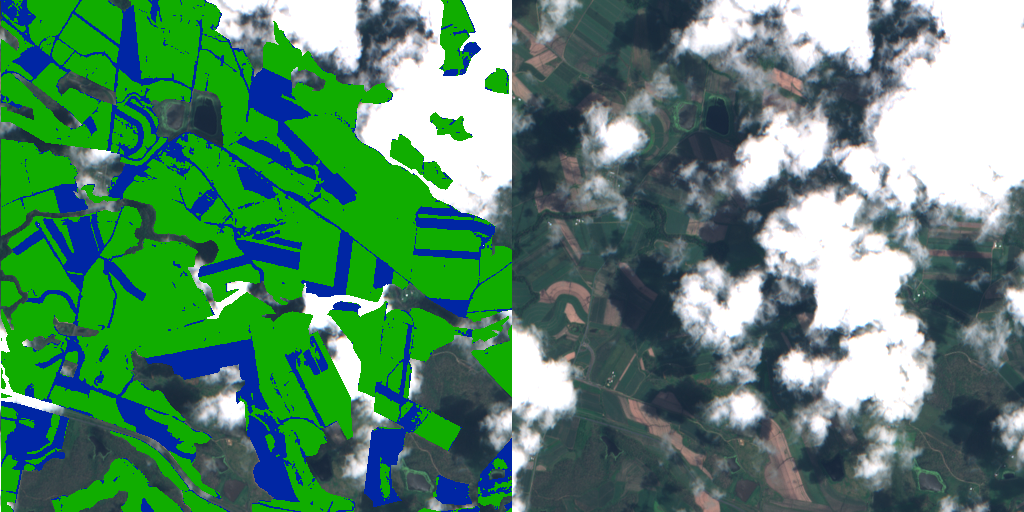

In [48]:
clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))
clusterImg

# Load Targeted Regions

In [67]:
# Selected 5 Tiles for our project
IterrateTiles = pd.DataFrame()
IterrateTiles['Unclean'] = onlyfiles
IterrateTiles['Unclean'].str.split('-',expand=True)
IterrateTiles['X Tile'] =  IterrateTiles['Unclean'].str.split('-',expand=True)[0]
IterrateTiles['Y Tile'] =  IterrateTiles['Unclean'].str.split('-',expand=True)[1]
IterrateTiles['TileTuple'] = IterrateTiles['X Tile'].astype(str) + " "+ IterrateTiles['Y Tile'].astype(str)
print(len(IterrateTiles['TileTuple'].unique()))
IterrateTiles.head()

Exception ignored in: <function JavaWrapper.__del__ at 0x0000029BB2935EA0>
Traceback (most recent call last):
  File "C:\Users\kunal\Anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'KMeans' object has no attribute '_java_obj'


65


,Unclean,X Tile,Y Tile,TileTuple
0,1536-1024-B01-2016-12-22.png,1536,1024,1536 1024
1,1536-1024-B01-2017-01-01.png,1536,1024,1536 1024
2,1536-1024-B01-2017-01-11.png,1536,1024,1536 1024
3,1536-1024-B01-2017-02-10.png,1536,1024,1536 1024
4,1536-1024-B01-2017-02-20.png,1536,1024,1536 1024


In [68]:
len(IterrateTiles['TileTuple'].unique())

65

In [69]:
SelectedTiles = ['7680 10240']
SelecteDF  = IterrateTiles[IterrateTiles['TileTuple'].isin(SelectedTiles)]
SelecteDF = SelecteDF[['X Tile','Y Tile','TileTuple']].drop_duplicates()
SelecteDF.head()

,X Tile,Y Tile,TileTuple
58646,7680,10240,7680 10240


In [84]:
Kmean = model

In [88]:
for index,row in SelecteDF.iterrows():
#     X_Tile = 
#     Y_Tile = 
    TILE_X = row['X Tile']
    TILE_Y = row['Y Tile']

    (start_x, start_y) = (0, 0)
    (size_x, size_y) = (512, 512)
    cropbox = (start_x, start_y, start_x + size_x, start_y + size_y)
    
    mask_path = get_mask_path(TILE_X, TILE_Y)
    masp = open_image(mask_path, mode = 'P', cropbox = cropbox)
    mask_pixels = pixels_in_mask(7680, 10240)
    tci_list = get_timeseries_image_paths(TILE_X, TILE_Y, 'TCI')

    b_name_list = [f'B{b:02d}' for b in range(1,13)]
    b_path_lol = [get_timeseries_image_paths(TILE_X, TILE_Y, b) for b in b_name_list]

    ModelDF = pd.DataFrame()
    assert len(tci_list) == len(b_path_lol[0])
    (tile_x, tile_y) = (TILE_X, TILE_Y)
    for day_no in trange(0,4): # len(tci_list)):
        tci_path = tci_list[day_no]
        date = last_date_in_path(tci_path)
        b_path_list = [b_path_list[day_no] for b_path_list in b_path_lol]

        tci_img = open_image(tci_path, cropbox = cropbox, verbose=False)
        b_img_list = [open_image(b_path, cropbox = cropbox, verbose=False) for b_path in b_path_list]

        data = read_img_pixel_values(tile_x, tile_y, date, masp, tci_img, *b_img_list)

        df = pd.DataFrame(columns=columns, data=data)
    # apply a very very simple havested rules
        df['clouds'] = df.apply(lambda df : df.red == df.green and df.red == df.blue, axis=1)
        df['havested'] = df.apply(lambda df : df.red > df.green, axis=1)

    # Calculate Indices:
    # https://support.micasense.com/hc/en-us/articles/227837307-An-overview-of-the-available-layers-and-indices-in-Atlas
    # https://support.micasense.com/hc/en-us/articles/226531127-Creating-agricultural-indices-NDVI-NDRE-from-an-Atlas-GeoTIFF-in-QGIS-
    # https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
    # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/
    # NDVI ref: https://medium.com/analytics-vidhya/satellite-imagery-analysis-with-python-3f8ccf8a7c32

    # NDVI - Normalised Difference Vegetation Index (NDVI)
    #  = (NIR - RED) / (NIR + RED)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_361.js
        df['NDVI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B04)) / (df.B08 + df.B04)) , axis=1)

    # GNDVI - Green Normalized Difference NDVI
    #  = (NIR - GREEN)/(NIR + GREEN)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTm9ybWFsaXplZCBEaWZmZXJlbmNlIE5JUi9HcmVlbiBHcmVlbiBORFZJIChhYmJydi4gR05EVkkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKE5JUi1HUkVFTikvKE5JUitHUkVFTikKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD00MDEKLy8KCmxldCBpbmRleCA9IChCMDggLSBCMDMpIC8gKEIwOCArIEIwMyk7CmxldCBtaW4gPSAtMC44OTsKbGV0IG1heCA9IDAuODk7CmxldCB6ZXJvID0gMC4wOwoKLy8gY29sb3JCbGVuZCB3aWxsIHJldHVybiBhIGNvbG9yIHdoZW4gdGhlIGluZGV4IGlzIGJldHdlZW4gbWluIGFuZCBtYXggYW5kIHdoaXRlIHdoZW4gaXQgaXMgbGVzcyB0aGFuIG1pbi4KLy8gVG8gc2VlIGJsYWNrIHdoZW4gaXQgaXMgbW9yZSB0aGFuIG1heCwgdW5jb21tZW50IHRoZSBsYXN0IGxpbmUgb2YgY29sb3JCbGVuZC4KLy8gVGhlIG1pbi9tYXggdmFsdWVzIHdlcmUgY29tcHV0ZWQgYXV0b21hdGljYWxseSBhbmQgbWF5IGJlIHBvb3JseSBzcGVjaWZpZWQsIGZlZWwgZnJlZSB0byBjaGFuZ2UgdGhlbSB0byB0d2VhayB0aGUgZGlzcGxheWVkIHJhbmdlLgovLyBUaGlzIGluZGV4IGNyb3NzZXMgemVybywgc28gYSBkaXZlcmdpbmcgY29sb3IgbWFwIGlzIHVzZWQuIFRvIHR3ZWFrIHRoZSB2YWx1ZSBvZiB0aGUgYnJlYWsgaW4gdGhlIGNvbG9yIG1hcCwgY2hhbmdlIHRoZSB2YXJpYWJsZSAnemVybycuCgpsZXQgdW5kZXJmbG93X2NvbG9yID0gWzEsIDEsIDFdOwpsZXQgbG93X2NvbG9yID0gWzIwOC8yNTUsIDg4LzI1NSwgMTI2LzI1NV07CmxldCBoaWdoX2NvbG9yID0gWzI0MS8yNTUsIDIzNC8yNTUsIDIwMC8yNTVdOwpsZXQgemVyb19jb2xvciA9IFswLCAxNDcvMjU1LCAxNDYvMjU1XTsKbGV0IG92ZXJmbG93X2NvbG9yID0gWzAsIDAsIDBdOwoKcmV0dXJuIGNvbG9yQmxlbmQoaW5kZXgsIFttaW4sIG1pbiwgemVybywgbWF4XSwKWwoJdW5kZXJmbG93X2NvbG9yLAoJbG93X2NvbG9yLAoJemVyb19jb2xvciwgLy8gZGl2ZXJnZW50IHN0ZXAgYXQgemVybwoJaGlnaF9jb2xvciwKCS8vb3ZlcmZsb3dfY29sb3IgLy8gdW5jb21tZW50IHRvIHNlZSBvdmVyZmxvd3MKXSk7DQo%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_401.js
        df['GNDVI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B03)) / (df.B08 + df.B03)) , axis=1)

    # RDVI - Normalised Difference Vegetation Index (NDVI)
    #  = 2*(NIR - RED) / sqrt(NIR + RED)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gUmVub3JtYWxpemVkIERpZmZlcmVuY2UgVmVnZXRhdGlvbiBJbmRleCAgIChhYmJydi4gUkRWSSkKLy8KLy8gR2VuZXJhbCBmb3JtdWxhOiAoODAwbm0gLSA2NzBubSkgL3NxcnQoODAwbm0gKyA2NzBubSkwLjUKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD03NgovLwoKbGV0IGluZGV4ID0gKEIwOCAtIEIwNCkgLyBNYXRoLnNxcnQoQjA4ICsgQjA0KSAqIDAuNTsKbGV0IG1pbiA9IC0wLjI2NjsKbGV0IG1heCA9IDAuMjY2OwpsZXQgemVybyA9IDAuMDsKCi8vIGNvbG9yQmxlbmQgd2lsbCByZXR1cm4gYSBjb2xvciB3aGVuIHRoZSBpbmRleCBpcyBiZXR3ZWVuIG1pbiBhbmQgbWF4IGFuZCB3aGl0ZSB3aGVuIGl0IGlzIGxlc3MgdGhhbiBtaW4uCi8vIFRvIHNlZSBibGFjayB3aGVuIGl0IGlzIG1vcmUgdGhhbiBtYXgsIHVuY29tbWVudCB0aGUgbGFzdCBsaW5lIG9mIGNvbG9yQmxlbmQuCi8vIFRoZSBtaW4vbWF4IHZhbHVlcyB3ZXJlIGNvbXB1dGVkIGF1dG9tYXRpY2FsbHkgYW5kIG1heSBiZSBwb29ybHkgc3BlY2lmaWVkLCBmZWVsIGZyZWUgdG8gY2hhbmdlIHRoZW0gdG8gdHdlYWsgdGhlIGRpc3BsYXllZCByYW5nZS4KLy8gVGhpcyBpbmRleCBjcm9zc2VzIHplcm8sIHNvIGEgZGl2ZXJnaW5nIGNvbG9yIG1hcCBpcyB1c2VkLiBUbyB0d2VhayB0aGUgdmFsdWUgb2YgdGhlIGJyZWFrIGluIHRoZSBjb2xvciBtYXAsIGNoYW5nZSB0aGUgdmFyaWFibGUgJ3plcm8nLgoKbGV0IHVuZGVyZmxvd19jb2xvciA9IFsxLCAxLCAxXTsKbGV0IGxvd19jb2xvciA9IFsyMDgvMjU1LCA4OC8yNTUsIDEyNi8yNTVdOwpsZXQgaGlnaF9jb2xvciA9IFsyNDEvMjU1LCAyMzQvMjU1LCAyMDAvMjU1XTsKbGV0IHplcm9fY29sb3IgPSBbMCwgMTQ3LzI1NSwgMTQ2LzI1NV07CmxldCBvdmVyZmxvd19jb2xvciA9IFswLCAwLCAwXTsKCnJldHVybiBjb2xvckJsZW5kKGluZGV4LCBbbWluLCBtaW4sIHplcm8sIG1heF0sClsKCXVuZGVyZmxvd19jb2xvciwKCWxvd19jb2xvciwKCXplcm9fY29sb3IsIC8vIGRpdmVyZ2VudCBzdGVwIGF0IHplcm8KCWhpZ2hfY29sb3IsCgkvL292ZXJmbG93X2NvbG9yIC8vIHVuY29tbWVudCB0byBzZWUgb3ZlcmZsb3dzCl0pOw0K&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_76.js
        df['RDVI'] = df.apply(lambda df : int(10000 * 2 * (float(df.B08) - float(df.B04)) / sqrt(df.B08 + df.B04)) , axis=1)

    # RBNDVI - Red Blue Normalised Difference Vegetation Index (NDVI)
    #  = (NIR - RED -BLUE) / (NIR + RED + BLUE)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gUmVkLUJsdWUgTkRWSSAgKGFiYnJ2LiBSQk5EVkkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKE5JUi0oUkVEK0JMVUUpKS8oTklSKyhSRUQrQkxVRSkpCi8vCi8vIFVSTCBodHRwczovL3d3dy5pbmRleGRhdGFiYXNlLmRlL2RiL3NpLXNpbmdsZS5waHA%2Fc2Vuc29yX2lkPTk2JnJzaW5kZXhfaWQ9MTg3Ci8vCgpsZXQgaW5kZXggPSAoQjA4IC0gKEIwNCArIEIwMikpIC8gKEIwOCArIChCMDQgKyBCMDIpKTsKbGV0IG1pbiA9IC0wLjkzOTsKbGV0IG1heCA9IDAuNTI5OwpsZXQgemVybyA9IDAuMDsKCi8vIGNvbG9yQmxlbmQgd2lsbCByZXR1cm4gYSBjb2xvciB3aGVuIHRoZSBpbmRleCBpcyBiZXR3ZWVuIG1pbiBhbmQgbWF4IGFuZCB3aGl0ZSB3aGVuIGl0IGlzIGxlc3MgdGhhbiBtaW4uCi8vIFRvIHNlZSBibGFjayB3aGVuIGl0IGlzIG1vcmUgdGhhbiBtYXgsIHVuY29tbWVudCB0aGUgbGFzdCBsaW5lIG9mIGNvbG9yQmxlbmQuCi8vIFRoZSBtaW4vbWF4IHZhbHVlcyB3ZXJlIGNvbXB1dGVkIGF1dG9tYXRpY2FsbHkgYW5kIG1heSBiZSBwb29ybHkgc3BlY2lmaWVkLCBmZWVsIGZyZWUgdG8gY2hhbmdlIHRoZW0gdG8gdHdlYWsgdGhlIGRpc3BsYXllZCByYW5nZS4KLy8gVGhpcyBpbmRleCBjcm9zc2VzIHplcm8sIHNvIGEgZGl2ZXJnaW5nIGNvbG9yIG1hcCBpcyB1c2VkLiBUbyB0d2VhayB0aGUgdmFsdWUgb2YgdGhlIGJyZWFrIGluIHRoZSBjb2xvciBtYXAsIGNoYW5nZSB0aGUgdmFyaWFibGUgJ3plcm8nLgoKbGV0IHVuZGVyZmxvd19jb2xvciA9IFsxLCAxLCAxXTsKbGV0IGxvd19jb2xvciA9IFsyMDgvMjU1LCA4OC8yNTUsIDEyNi8yNTVdOwpsZXQgaGlnaF9jb2xvciA9IFsyNDEvMjU1LCAyMzQvMjU1LCAyMDAvMjU1XTsKbGV0IHplcm9fY29sb3IgPSBbMCwgMTQ3LzI1NSwgMTQ2LzI1NV07CmxldCBvdmVyZmxvd19jb2xvciA9IFswLCAwLCAwXTsKCnJldHVybiBjb2xvckJsZW5kKGluZGV4LCBbbWluLCBtaW4sIHplcm8sIG1heF0sClsKCXVuZGVyZmxvd19jb2xvciwKCWxvd19jb2xvciwKCXplcm9fY29sb3IsIC8vIGRpdmVyZ2VudCBzdGVwIGF0IHplcm8KCWhpZ2hfY29sb3IsCgkvL292ZXJmbG93X2NvbG9yIC8vIHVuY29tbWVudCB0byBzZWUgb3ZlcmZsb3dzCl0pOw0K&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_187.js
        df['RBNDVI'] = df.apply(lambda df : int(10000 * (2*float(df.B08) - float(df.B04) - float(df.B02)) / (2*df.B08 + df.B04 + df.B02)) , axis=1)

    # LCI - Leaf Chlorophyll Index
    #  = (NIR - REDE)/(NIR + REDE)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTGVhZiBDaGxvcm9waHlsbCBJbmRleCAgKGFiYnJ2LiBMQ0kpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFs4NTBdLVs3MTBdKS8oWzg1MF0rWzY4MF0pCi8vCi8vIFVSTCBodHRwczovL3d3dy5pbmRleGRhdGFiYXNlLmRlL2RiL3NpLXNpbmdsZS5waHA%2Fc2Vuc29yX2lkPTk2JnJzaW5kZXhfaWQ9MTA5Ci8vCgpsZXQgaW5kZXggPSAoQjA4IC0gQjA1KSAvIChCMDggKyBCMDQpOwpsZXQgbWluID0gLTIuNzk4OwpsZXQgbWF4ID0gMC43MzU7CmxldCB6ZXJvID0gMC4wOwoKLy8gY29sb3JCbGVuZCB3aWxsIHJldHVybiBhIGNvbG9yIHdoZW4gdGhlIGluZGV4IGlzIGJldHdlZW4gbWluIGFuZCBtYXggYW5kIHdoaXRlIHdoZW4gaXQgaXMgbGVzcyB0aGFuIG1pbi4KLy8gVG8gc2VlIGJsYWNrIHdoZW4gaXQgaXMgbW9yZSB0aGFuIG1heCwgdW5jb21tZW50IHRoZSBsYXN0IGxpbmUgb2YgY29sb3JCbGVuZC4KLy8gVGhlIG1pbi9tYXggdmFsdWVzIHdlcmUgY29tcHV0ZWQgYXV0b21hdGljYWxseSBhbmQgbWF5IGJlIHBvb3JseSBzcGVjaWZpZWQsIGZlZWwgZnJlZSB0byBjaGFuZ2UgdGhlbSB0byB0d2VhayB0aGUgZGlzcGxheWVkIHJhbmdlLgovLyBUaGlzIGluZGV4IGNyb3NzZXMgemVybywgc28gYSBkaXZlcmdpbmcgY29sb3IgbWFwIGlzIHVzZWQuIFRvIHR3ZWFrIHRoZSB2YWx1ZSBvZiB0aGUgYnJlYWsgaW4gdGhlIGNvbG9yIG1hcCwgY2hhbmdlIHRoZSB2YXJpYWJsZSAnemVybycuCgpsZXQgdW5kZXJmbG93X2NvbG9yID0gWzEsIDEsIDFdOwpsZXQgbG93X2NvbG9yID0gWzIwOC8yNTUsIDg4LzI1NSwgMTI2LzI1NV07CmxldCBoaWdoX2NvbG9yID0gWzI0MS8yNTUsIDIzNC8yNTUsIDIwMC8yNTVdOwpsZXQgemVyb19jb2xvciA9IFswLCAxNDcvMjU1LCAxNDYvMjU1XTsKbGV0IG92ZXJmbG93X2NvbG9yID0gWzAsIDAsIDBdOwoKcmV0dXJuIGNvbG9yQmxlbmQoaW5kZXgsIFttaW4sIG1pbiwgemVybywgbWF4XSwKWwoJdW5kZXJmbG93X2NvbG9yLAoJbG93X2NvbG9yLAoJemVyb19jb2xvciwgLy8gZGl2ZXJnZW50IHN0ZXAgYXQgemVybwoJaGlnaF9jb2xvciwKCS8vb3ZlcmZsb3dfY29sb3IgLy8gdW5jb21tZW50IHRvIHNlZSBvdmVyZmxvd3MKXSk7DQo%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_109.js
        df['LCI'] = df.apply(lambda df : int(100 * (float(df.B08) - float(df.B05)) / (df.B08 + df.B05)) , axis=1)

    # LAI - Leaf Area Index
    #  = (REDE - RED)/(REDE + RED)
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231680/
        df['LAI'] = df.apply(lambda df : int(10000 * (float(df.B05) - float(df.B04)) / (df.B05 + df.B04)) , axis=1)

    # SCI - Soil Composition Index
    #  = (SWIR - NIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gU29pbCBDb21wb3NpdGlvbiBJbmRleCAgKGFiYnJ2LiApCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFsxNjAwOjE3MDBdLVs3NjA6ODYwXSkvKFsxNjAwOjE3MDBdK1s3NjA6ODYwXSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD04OAovLwoKbGV0IGluZGV4ID0gKEIxMSAtIEIwOCkgLyAoQjExICsgQjA4KTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_88.js
        df['SCI'] = df.apply(lambda df : int(10000 * (float(df.B11) - float(df.B08)) / (df.B11 + df.B08)) , axis=1)

    # SCI - Soil Composition Index
    #  = (SWIR - NIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gU29pbCBDb21wb3NpdGlvbiBJbmRleCAgKGFiYnJ2LiApCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFsxNjAwOjE3MDBdLVs3NjA6ODYwXSkvKFsxNjAwOjE3MDBdK1s3NjA6ODYwXSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD04OAovLwoKbGV0IGluZGV4ID0gKEIxMSAtIEIwOCkgLyAoQjExICsgQjA4KTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_88.js
        df['SCI'] = df.apply(lambda df : int(10000 * (float(df.B11) - float(df.B08)) / (df.B11 + df.B08)) , axis=1)

    # NDMI - Normalized Difference Moisture Index
    #  = (NIR - SWIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTm9ybWFsaXplZCBEaWZmZXJlbmNlIDgyMC8xNjAwIE5vcm1hbGl6ZWQgRGlmZmVyZW5jZSBNb2lzdHVyZSBJbmRleCAoYWJicnYuIE5ETUkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKDgyMG5tIC0gMTYwMG5tKSAvICg4MjBubSArIDE2MDBubSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD01NgovLwoKbGV0IGluZGV4ID0gKEIwOCAtIEIxMSkgLyAoQjA4ICsgQjExKTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_56.js
        df['NDMI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B11)) / (df.B11 + df.B08)) , axis=1)
    
    # GLI - Green Leaf Index
    #  = (2*GREEN - RED - BLUE)/(2*GREEN + RED + BLUE)
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231680/
        df['GLI'] = df.apply(lambda df : int(10000 * (float(df.B05) - float(df.B04)) / (df.B05 + df.B04)) , axis=1)
    
#        ModelDF = pd.concat([ModelDF,df]).reset_index(drop=True)
        df = df[(df['red']<225)&(df['green']<225)&(df['blue']<225)].reset_index(drop=True)

        df['Scaled_NIR'] = min_max_scaler.fit_transform(df[['B08']])
        df['Scaled_RED'] = min_max_scaler.fit_transform(df[['B04']])
        df['Scaled_GRN'] = min_max_scaler.fit_transform(df[['B03']])
        df['Scaled_NDVI'] = min_max_scaler.fit_transform(df[['NDVI']])
        df['Scaled_LCI'] = min_max_scaler.fit_transform(df[['LCI']])
        df['Scaled_LAI'] = min_max_scaler.fit_transform(df[['LAI']])
        df['Scaled_SCI'] = min_max_scaler.fit_transform(df[['SCI']])
        df['Scaled_GNDVI'] = min_max_scaler.fit_transform(df[['GNDVI']])

        df['PixelTuple'] = df['x'].astype(str) + " " + df['y'].astype(str)

#         dfMask = df[df['PixelTuple'].isin(mask_pixels)].reset_index(drop=True)

        

        df = df[(df['red']<225)&(df['green']<225)&(df['blue']<225)].reset_index(drop=True)

        df['Scaled_NIR'] = min_max_scaler.fit_transform(df[['B08']])
        df['Scaled_RED'] = min_max_scaler.fit_transform(df[['B04']])
        df['Scaled_GRN'] = min_max_scaler.fit_transform(df[['B03']])
        df['Scaled_NDVI'] = min_max_scaler.fit_transform(df[['NDVI']])
        df['Scaled_LCI'] = min_max_scaler.fit_transform(df[['LCI']])
        df['Scaled_LAI'] = min_max_scaler.fit_transform(df[['LAI']])
        df['Scaled_SCI'] = min_max_scaler.fit_transform(df[['SCI']])
        df['Scaled_GNDVI'] = min_max_scaler.fit_transform(df[['GNDVI']])

        df['PixelTuple'] = df['x'].astype(str) + " " + df['y'].astype(str)
        dfMask = df[df['PixelTuple'].isin(mask_pixels)].reset_index(drop=True)
        dfMask['prediction']= Kmean.predict(dfMask[vegi1InputCols])
        tciFilePath = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles\\'+ str(TILE_X)+"-"+ str(TILE_Y) + "-TCI-" + date+'.png'
#         tciFilePath = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Phase02-DataDelivery\\sugarcanetiles\\7680-10240-TCI-2017-06-20.png'
        tci = open_image(tciFilePath, mode='RGB')
        numberOfClusters = 2
        vegiClustered_df = dfMask[['x','y','prediction']]
        colours = []
        for colour in range(0, numberOfClusters):
            red = colour * 0xFF / numberOfClusters
            grn = 0xFF - abs(2 * colour - numberOfClusters) * 0xFF / numberOfClusters
            blu = 0xFF - colour * 0xFF / numberOfClusters
    #colours.append(np.array([blu,grn,red,], dtype='uint8'))
            colours.append(np.array([grn,red,blu,], dtype='uint8'))
    #colours.append(np.array([red,grn,blu,], dtype='uint8'))
        colours = [
            np.array([0x10,0xAD,0x00], dtype='uint8'),  # limish green
            np.array([0x00,0x26,0xA4], dtype='uint8'),  # blueish
            np.array([0xFF,0x00,0x00], dtype='uint8'),  # red
            np.array([0xFF,0xC6,0x00], dtype='uint8'),  # yellow
            np.array([0x00, 0x00, 0x00],dtype='uint8')
            ]

        clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))
        imgnp = overlayPredictionImage(vegiClustered_df, tci, colours)

        clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))
        path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Github\\Dash-Application\\CompImages\\'
        path += f"comp_image_{TILE_X}_{TILE_Y}_{date}.png"
        print(type(clusterImg))
        clusterImg.save(path)
# clusterImg.to
        path = 'C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\Github\\Dash-Application\\Parquets\\'
        path += f"image_values_{TILE_X}_{TILE_Y}_{date}.snappy.parquet"
        vegiClustered_df.to_parquet(path)


C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\masks\mask-x7680-y10240.png
Format: None
Size: (512, 512)
Mode: P
width: 512 height: 512







  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by M

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2016-12-22.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512
<class 'PIL.Image.Image'>







 25%|████████████████████▊                                                              | 1/4 [02:19<06:59, 139.95s/it]C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by M

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2017-01-01.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512
<class 'PIL.Image.Image'>







 50%|█████████████████████████████████████████▌                                         | 2/4 [04:50<04:46, 143.26s/it]C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by M

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2017-01-11.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512
<class 'PIL.Image.Image'>







 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [07:38<02:30, 150.50s/it]C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by M

C:\Users\kunal\Desktop\WORK\Datathon\Phase02-DataDelivery\sugarcanetiles\7680-10240-TCI-2017-02-10.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512
<class 'PIL.Image.Image'>







100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:01<00:00, 148.34s/it]






In [ ]:
df.head(1)

In [ ]:
import json
from pprint import pprint

with open('C:\\Users\\kunal\\Desktop\\WORK\\Datathon\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\metadata\\2016-12-22.json') as f:
    data = json.load(f)

In [ ]:
print(data['cloud-cover'])

In [ ]:
data